In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.rcParams['figure.figsize'] = [16, 8]

In [2]:
cliff = pd.read_csv('../data/cliff_joined.csv')
mp = pd.read_csv('../data/mp_joined.csv')

## Merging big wall cliffs to MP data

Running a merging operation to join the two dataframes. Earth Engine could not handle this calculation.

In [3]:
cliff['mp_counts'] = 0
cliff['num_rock_routes'] = 0
cliff['num_views'] = 0
cliff['distance_to_mp'] = None

for i, row in tqdm(cliff.iterrows(), total=cliff.shape[0]):
    filtered = mp[mp.custom_index == row.custom_index]
    mp_count = filtered.shape[0]
    if mp_count:
        cliff.at[i, 'mp_counts'] = mp_count
        cliff.at[i, 'num_rock_routes'] = filtered.num_rock_routes.sum()
        cliff.at[i, 'num_views'] = filtered.num_views.sum()
        cliff.at[i, 'distance_to_mp'] = filtered.distance_to_mp.mean()

100%|██████████| 72963/72963 [01:26<00:00, 842.11it/s] 


Now everything we need is inside the `cliff` dataframe. Dropping some left-over columns from Earth Engine and stuff we don't need.

In [4]:
cliff.drop(columns=['system:index', '.geo', 'custom_index', 'vicinity_mp_areas'], inplace=True)
for name in cliff.columns:
    print(name)

B2_p20
B2_p35
B2_p50
B2_p65
B2_p80
B42_p20
B42_p35
B42_p50
B42_p65
B42_p80
B4_p20
B4_p35
B4_p50
B4_p65
B4_p80
B5_p20
B5_p35
B5_p50
B5_p65
B5_p80
B65_p20
B65_p35
B65_p50
B65_p65
B65_p80
B67_p20
B67_p35
B67_p50
B67_p65
B67_p80
B6_p20
B6_p35
B6_p50
B6_p65
B6_p80
B7_p20
B7_p35
B7_p50
B7_p65
B7_p80
B_p10
B_p20
B_p30
B_p40
B_p50
B_p60
B_p70
B_p80
B_p90
D_p10
D_p20
D_p30
D_p40
D_p50
D_p60
D_p70
D_p80
D_p90
G_p10
G_p20
G_p30
G_p40
G_p50
G_p60
G_p70
G_p80
G_p90
N_p10
N_p20
N_p30
N_p40
N_p50
N_p60
N_p70
N_p80
N_p90
R_p10
R_p20
R_p30
R_p40
R_p50
R_p60
R_p70
R_p80
R_p90
geology_alluvium
geology_carbonate
geology_colluvial_sediment
geology_glacial_till_coarse
geology_non_carbonate
geology_silicic_residual
height
latitude
longitude
pixel_count
population_within_100km
population_within_30km
population_within_60km
road_within_1000m
road_within_1500m
road_within_2000m
road_within_500m
slope_p10
slope_p20
slope_p30
slope_p40
slope_p50
slope_p60
slope_p70
slope_p80
slope_p90
vicinity_num_rock_routes
vici

## Exploring association between Earth Engine-generated cliffs and MP data

Checking out the cliffs with associated MP areas. Many MP areas have their geo-tags well aligned with the location of the cliff according to earth engine.

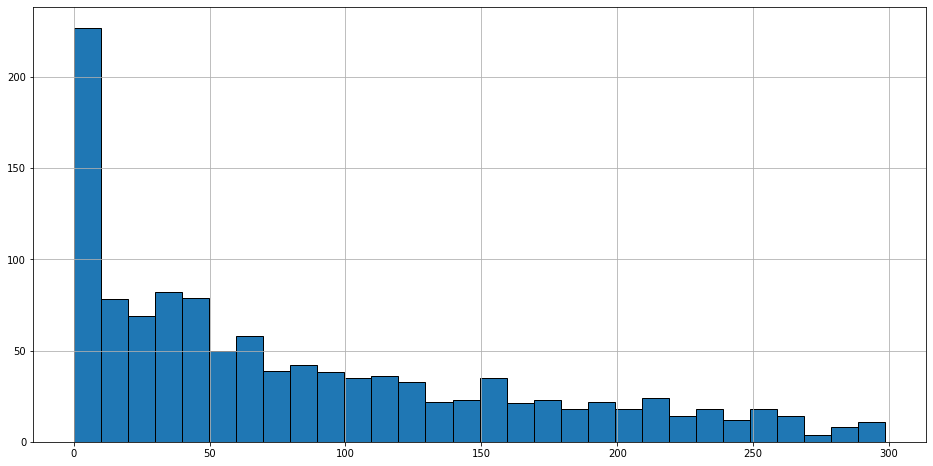

In [5]:
cliff.distance_to_mp.hist(bins=30, edgecolor='black', linewidth=1.0);

Most cliffs have no associated MP areas. Some have many.

In [6]:
for n in range(20):
    print((cliff.mp_counts == n).sum())

71792
920
147
48
23
10
9
6
2
2
2
0
1
0
1
0
0
0
0
0


Are big walls viewed more on MP? Not really...

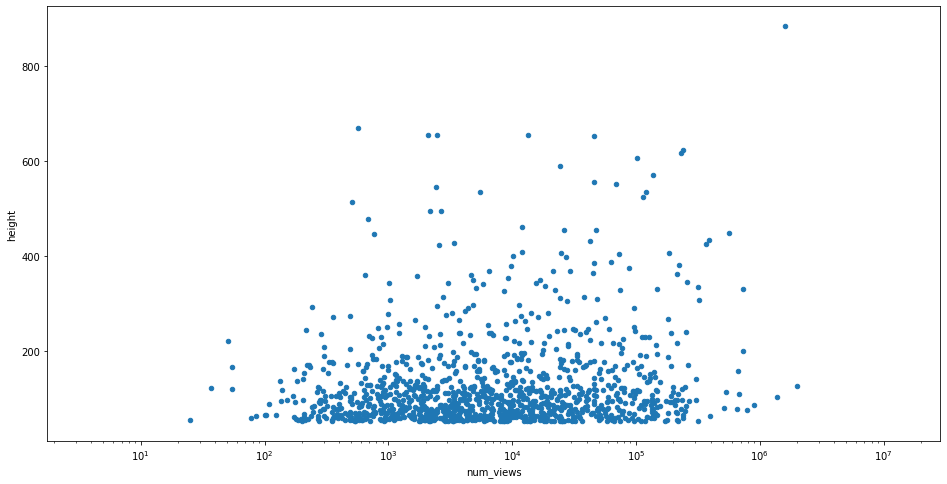

In [7]:
cliff[cliff.num_views > 0].plot(x='num_views', y='height', kind='scatter', logx=True);

But, as expected, big wall MP areas with more routes do get more views.

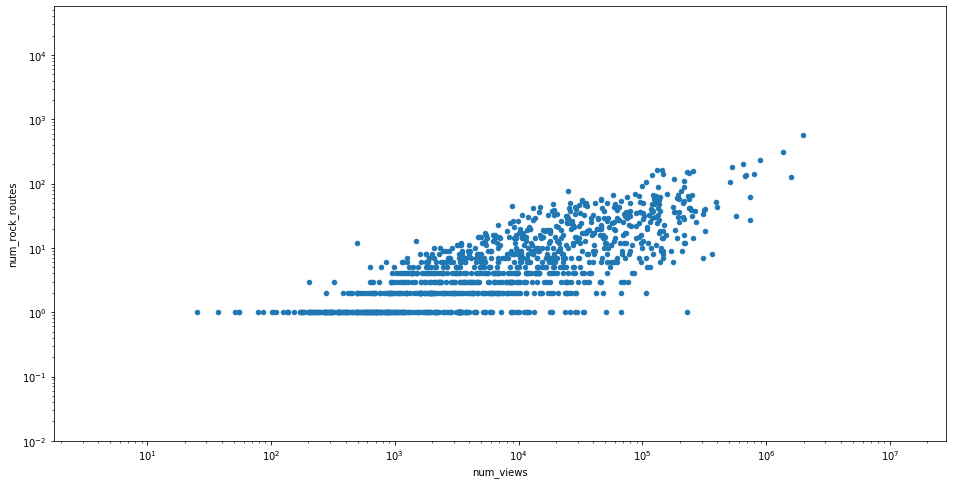

In [8]:
cliff[cliff.num_views > 0].plot(x='num_views', y='num_rock_routes', kind='scatter', loglog=True);

Cliffs for which MP geo tag doesn't align well with cliff location according to Earth Engine elevation data. These can be cross-referenced with the script in `ee_code_editor/explore_unmerged_data.js`. Some of these are aligned with actual cliffs; others are not.

In [9]:
cliff[cliff.distance_to_mp > 200][['latitude', 'longitude', 'height', 'num_rock_routes', 'distance_to_mp']].head(20)

,latitude,longitude,height,num_rock_routes,distance_to_mp
142,36.928193,-118.494490,51,1,294.997
271,37.095271,-118.510480,51,1,253.308
1622,45.221777,-114.686611,56,1,241.372
1674,37.169412,-118.670305,56,1,225.994
1877,37.471140,-119.256616,57,1,214.691
2004,37.093025,-118.516747,58,2,228.484
2207,38.122888,-119.408663,59,1,211.398
2383,43.704047,-110.817053,60,2,200.981
3274,43.718253,-110.815163,65,3,283.868
4251,36.632621,-118.530422,72,2,264.314


## Accessible cliffs

Eventually, we'll partition the data into two classes -- those that are accessible (and hence explored), and those that are inaccessible. Checking out possible partitions below.

In [10]:
print((cliff.num_views > 1000).sum())
print((cliff.vicinity_num_views > 5000).sum())
print(((cliff.road_within_500m == 1) & (cliff.population_within_30km > 10_000)).sum())
print(((cliff.road_within_1000m == 1) & (cliff.population_within_60km > 100_000)).sum())
print(((cliff.road_within_1500m == 1) & (cliff.population_within_100km > 1_000_000)).sum())
print(((cliff.road_within_2000m == 1) & (cliff.population_within_100km > 2_000_000)).sum())

961
3125
2734
3477
2482
2271


In [11]:
accessible = (cliff.num_views > 1000) | (cliff.vicinity_num_views > 5000) | \
            ((cliff.road_within_500m == 1) & (cliff.population_within_30km > 10_000)) | \
            ((cliff.road_within_1000m == 1) & (cliff.population_within_60km > 100_000)) | \
            ((cliff.road_within_1500m == 1) & (cliff.population_within_100km > 1_000_000)) | \
            ((cliff.road_within_2000m == 1) & (cliff.population_within_100km > 2_000_000))

print(f'Number of accessibles: {accessible.sum()}')
print(f'Number of positives: {(cliff.num_views > 1000).sum()}')

Number of accessibles: 8691
Number of positives: 961


This is somewhat bad news -- we have a fairly small training set, and the training set is unbalanced. Still, smaller is better than nothing.

## Noise in the data

There are "holes" in the elevation dataset found at 'USGS/NED'. These holes give the appearance of deep wells within the elevation data. They form regions in which the elevation at several pixels is much lower than all of the surrounding elevation, and hence give "false positives". Manually removing these holds after studying the plot of height vs pixel_count. This removes roughly 1000 data points. Points above the red line are removed.

In [12]:
cliff[cliff.height > 500].sort_values(by='height', ascending=False)[
      ['height', 'latitude', 'longitude', 'pixel_count', 'num_rock_routes']].head(20)

,height,latitude,longitude,pixel_count,num_rock_routes
56936,1517,38.914926,-105.447310,21,0
22814,1281,38.694533,-114.250880,129,0
27112,1243,35.680154,-118.371011,69,0
69839,1141,41.124762,-105.999862,23,0
69818,1141,41.125711,-105.999867,6,0
69816,1141,41.125761,-106.000065,1,0
69815,1141,41.125048,-106.000686,147,0
12681,884,37.732099,-119.635610,2448,125
7708,880,48.975383,-120.995997,701,0
7709,880,48.971820,-121.002123,206,0


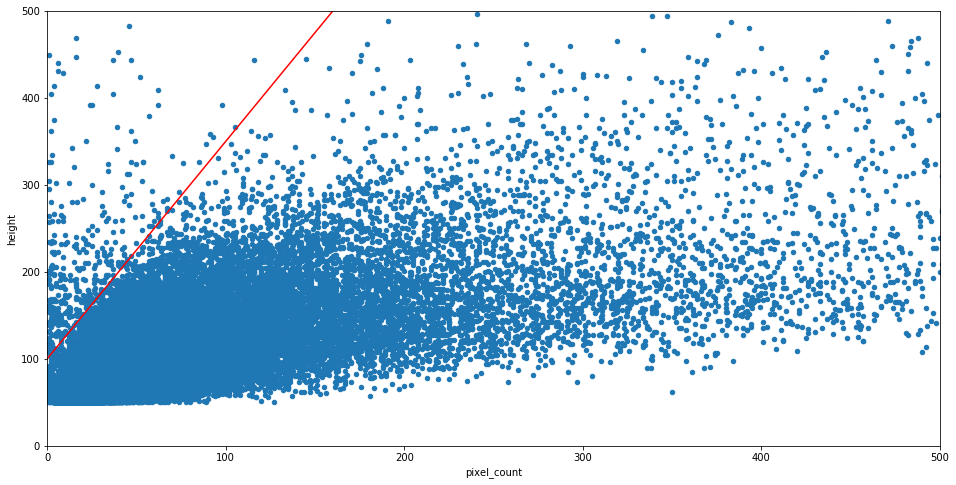

Number of data points removed: 6020


In [13]:
cliff.plot(x='pixel_count', y='height', kind='scatter', xlim=(0, 500), ylim=(0, 500))
line = lambda x: 2.5 * x + 100
plt.plot([0, 1000], [line(0), line(1000)], 'k-', color='red')
plt.show()
mask = (cliff.height < 2.5 * cliff.pixel_count + 100) & (cliff.pixel_count > 10)
print(f'Number of data points removed: {(~mask).sum()}')
cliff = cliff[mask]

Other bits of noise exist in the data. Removing a few landsat bands with negative values. Removing satellite data with null values.

In [14]:
mask = (cliff.B2_p20 > 0) & (cliff.B4_p20 > 0) & (cliff.B5_p20 > 0) & (cliff.B6_p20 > 0) & (cliff.B7_p20 > 0)
print(f'Number of data points removed: {(~mask).sum()}')
cliff = cliff[mask]

Number of data points removed: 71


In [15]:
mask = cliff.R_p10.notnull()
print(f'Number of data points removed: {(~mask).sum()}')
cliff = cliff[mask]

Number of data points removed: 24


## Other trends

Now we visualize possible correlations among data values. ML models will flesh these out.

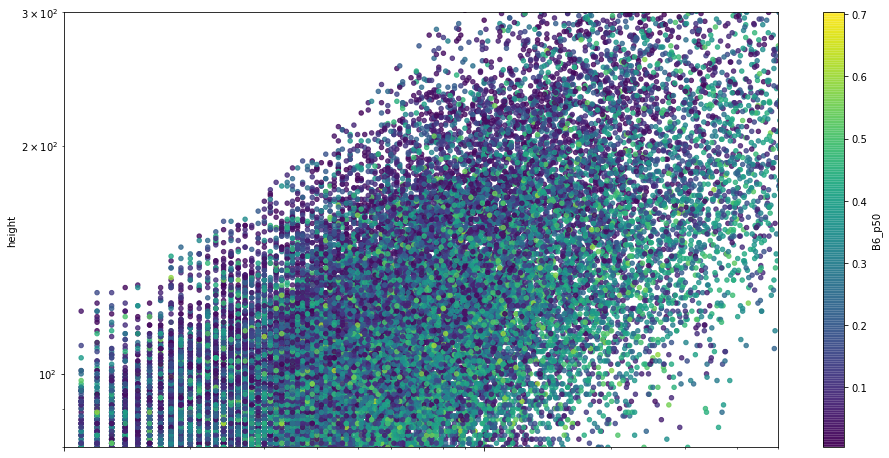

In [16]:
cliff.plot(x='pixel_count', y='height', c='B6_p50', alpha=0.8, kind='scatter',
        xlim=(10, 500), ylim=(80, 300), loglog=True, colormap='viridis');

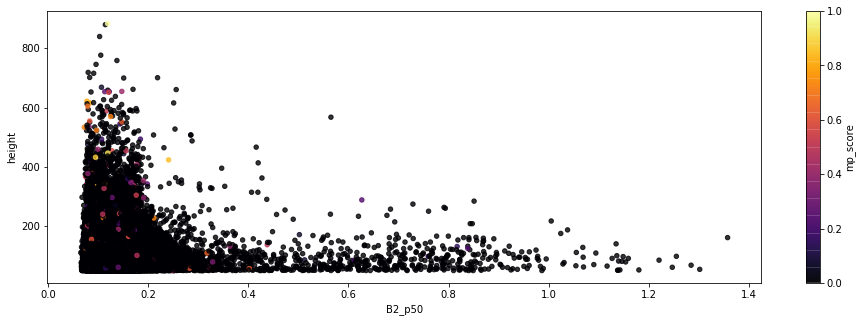

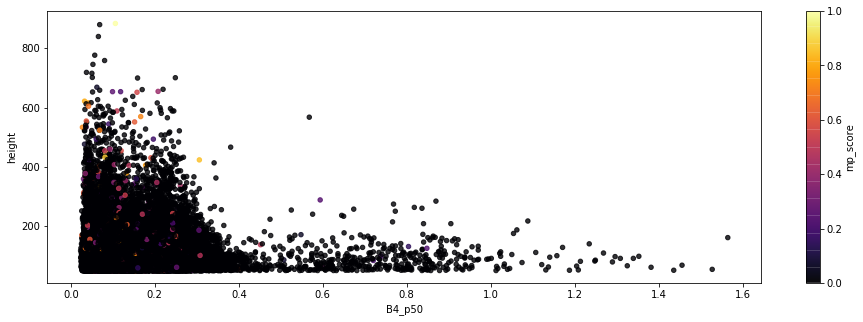

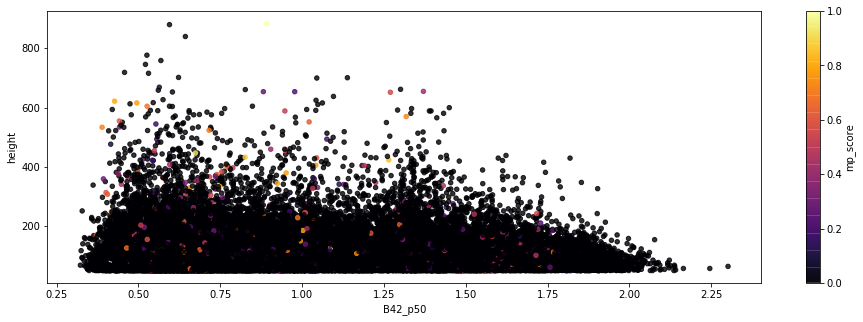

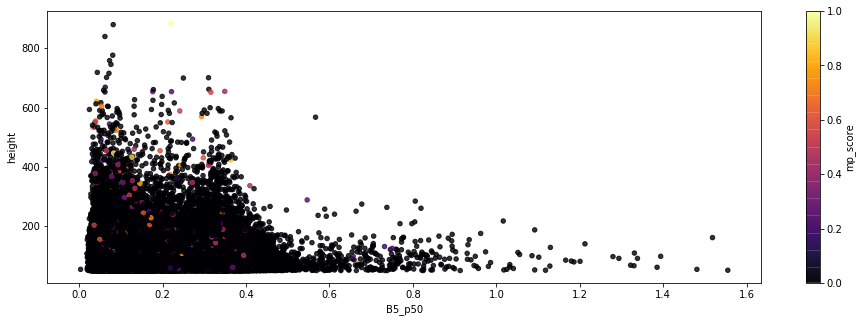

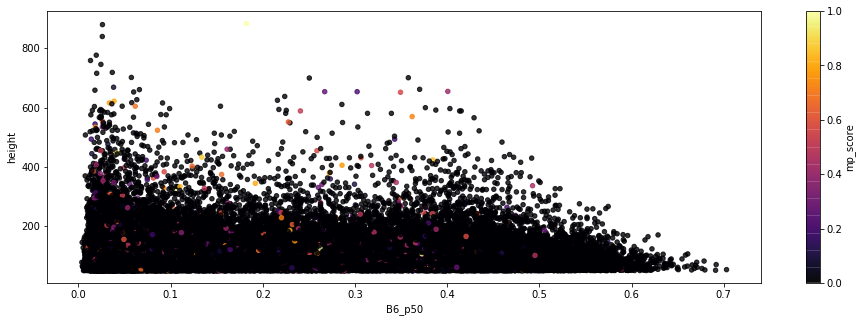

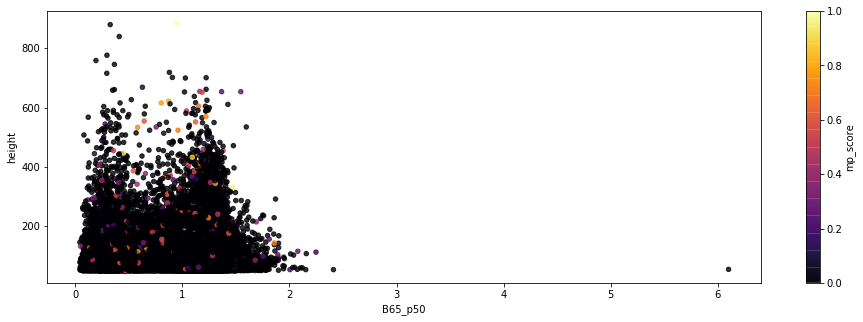

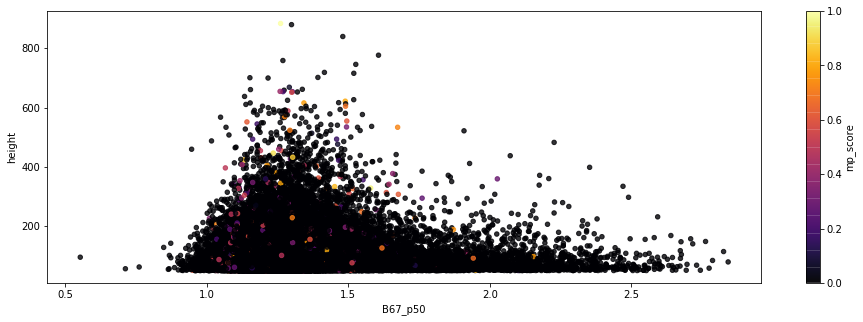

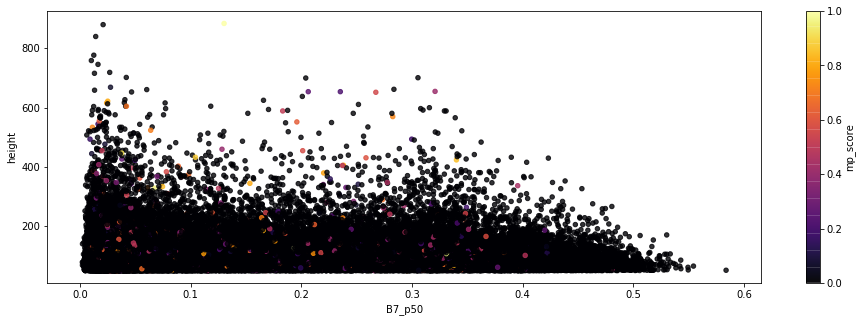

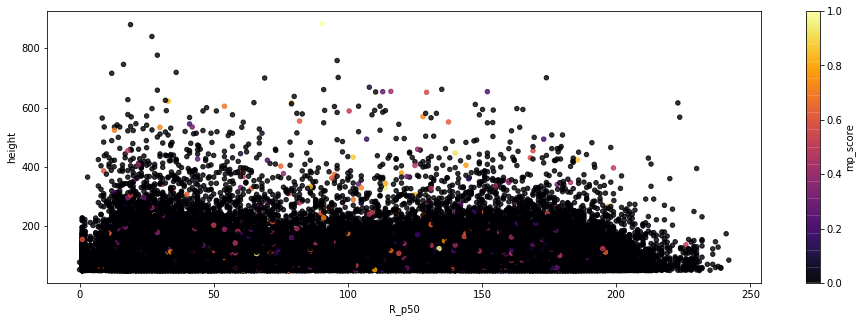

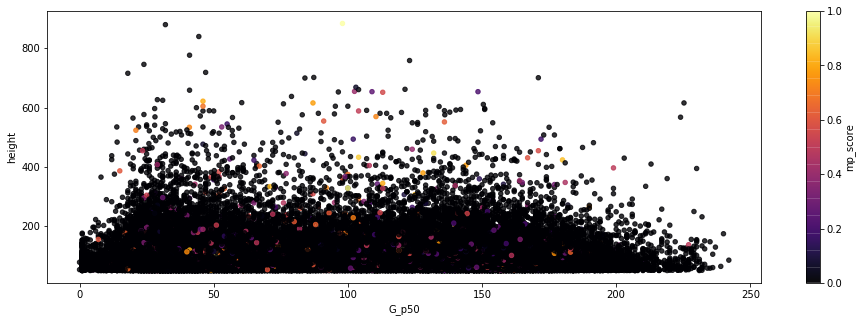

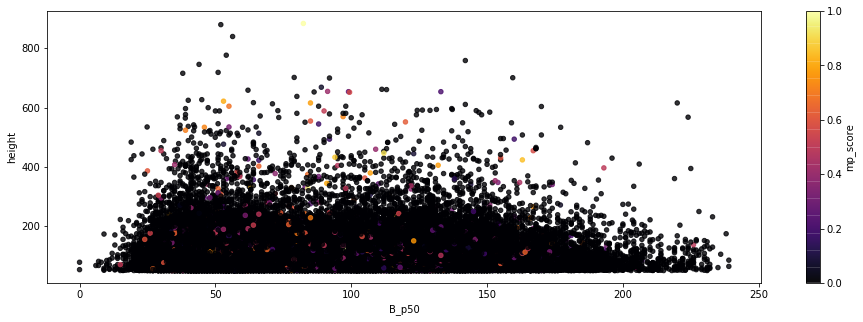

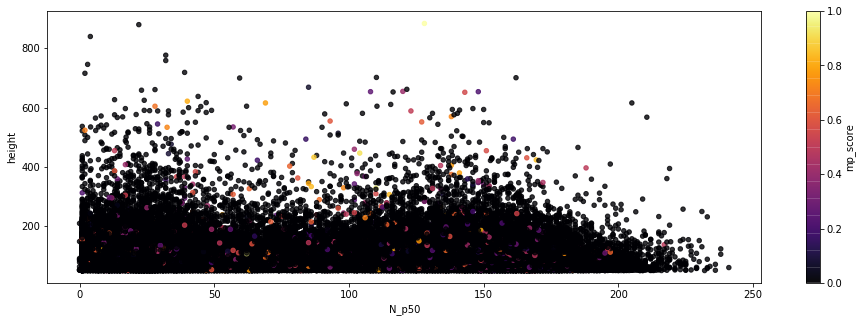

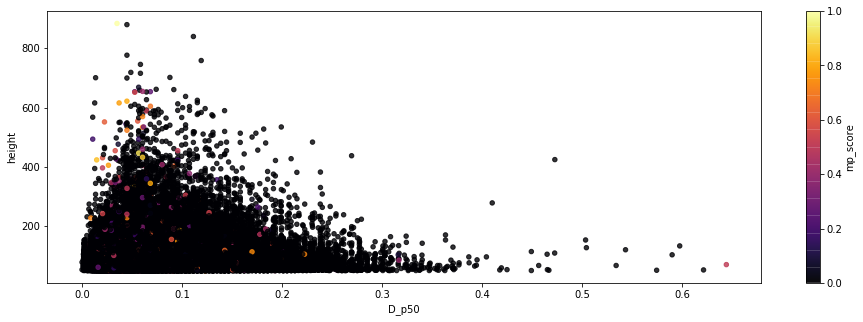

In [17]:
cliff['mp_score'] = (1000 * cliff.num_rock_routes + cliff.num_views).map(
    lambda x: 0 if x < 1000 else np.log2(x) / 10 - 1).clip(0, 1)


for label in ['B2_p50', 'B4_p50', 'B42_p50', 'B5_p50', 'B6_p50', 'B65_p50', 'B67_p50',
              'B7_p50', 'R_p50', 'G_p50', 'B_p50', 'N_p50', 'D_p50']:
    fig = plt.figure(figsize=(16, 5))
    ax = fig.add_subplot(111)
    cliff.plot(x=label, y='height', kind='scatter', c='mp_score', alpha=0.8, colormap='inferno', ax=ax)
    plt.show()

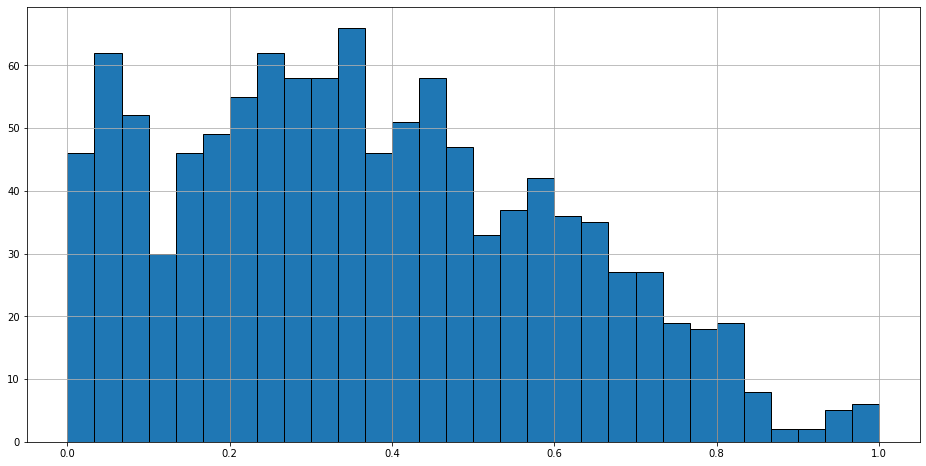

In [18]:
cliff.mp_score[cliff.mp_score > 0].hist(bins=30, edgecolor='black', linewidth=1.0);

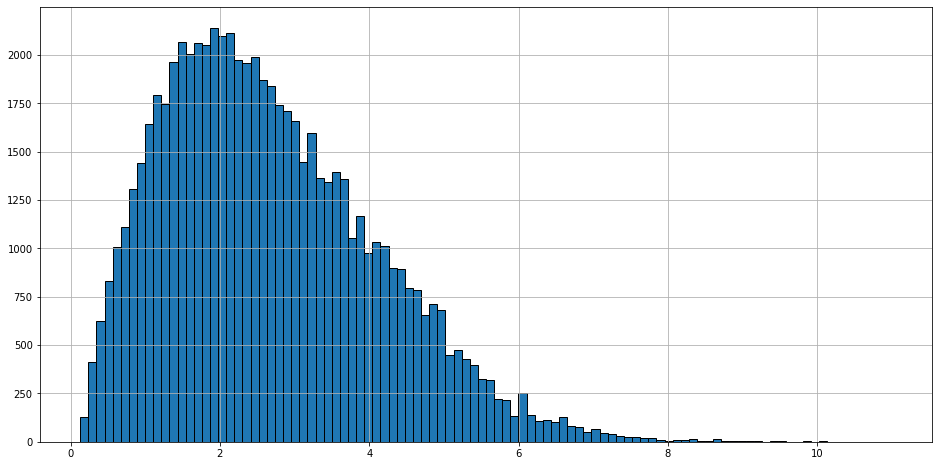

In [19]:
(cliff.height / cliff.pixel_count).hist(bins=100, edgecolor='black', linewidth=1.0);

Looking at crags with highest `mp_score`. El cap has a score of 1.0, as does some stuff in Eldo, Tahquitz, and Smith Rock.

In [20]:
cliff.sort_values(by='mp_score', ascending=False)[['mp_score', 'latitude', 'longitude', 'height', 'distance_to_mp']][:30]

,mp_score,latitude,longitude,height,distance_to_mp
12681,1.000000,37.732099,-119.635610,884,49.1862
69837,1.000000,39.931806,-105.286129,103,142.009
69849,1.000000,39.931306,-105.285291,125,153.078
57780,1.000000,33.760474,-116.683964,85,136.498
24914,0.982496,44.366045,-121.146574,74,26.1248
69848,0.969432,39.741467,-105.410153,76,156.896
71232,0.964086,38.547485,-109.598939,108,56.2307
17490,0.960709,36.035920,-115.468383,329,54.794
12999,0.960615,38.800169,-120.134699,156,118.26
9735,0.953903,43.742491,-110.803205,200,114.461
